In [1]:
import os
import random
import torch
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from collections import Counter
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models

In [2]:
!unzip /kaggle/input/platesv2/plates.zip > /dev/null 2>&1

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
train_dir = Path('/kaggle/working/plates/train')
test_dir = Path('/kaggle/working/plates/test')

train_dir, test_dir

(PosixPath('/kaggle/working/plates/train'),
 PosixPath('/kaggle/working/plates/test'))

In [25]:
train_transforms = transforms.Compose([
    # Основные геометрические преобразования
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=15,         # Поворот на ±15 градусов
            translate=(0.1, 0.1),  # Сдвиг на 10%
            scale=(0.9, 1.1),   # Масштабирование 90-110%
            shear=10            # Наклон до 10 градусов
        )
    ], p=0.7),
    
    # Проективные преобразования (более мягкие)
    transforms.RandomPerspective(
        distortion_scale=0.15,  # Уменьшил с 0.5 до 0.15 для меньших искажений
        p=0.5,                 # Вероятность 50%
        interpolation=transforms.InterpolationMode.BILINEAR,
        fill=255
    ),
    
    # Цветовые искажения
    transforms.ColorJitter(
        brightness=0.1,        # Яркость ±10%
        contrast=0.1,          # Контраст ±10%
        saturation=0.1,        # Насыщенность ±10%
        hue=0.05              # Оттенок ±5% (уменьшил с 0.5)
    ),
    
    # Шум (добавляем с небольшой вероятностью)
    transforms.RandomApply([
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.03),
    ], p=0.3),
    
    # Обязательные преобразования
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

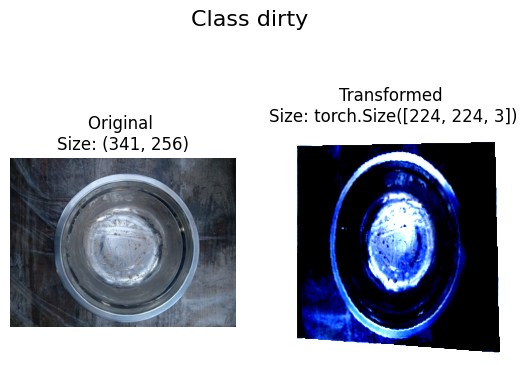

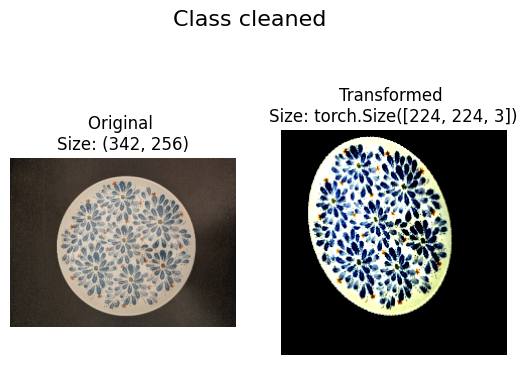

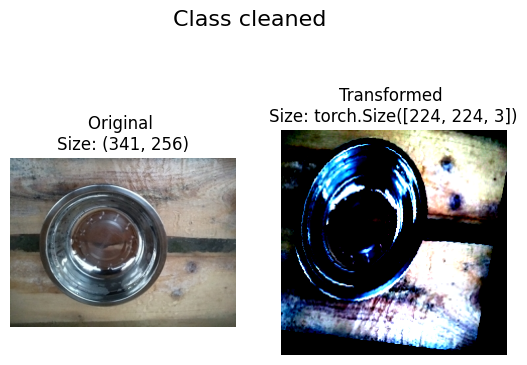

In [26]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
      with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f'Original \nSize: {f.size}')
        ax[0].axis('off')

        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis('off')

        fig.suptitle(f"Class {image_path.parent.stem}", fontsize=16)

image_path_list = list(train_dir.glob("*/*.jpg"))
plot_transformed_images(image_path_list,
                        transform=train_transforms,
                        n=3)

In [ ]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms,
                                  target_transform=None)

print(f"Train data:\n{train_data}")

In [ ]:
class_dict = {v:k for k, v in train_data.class_to_idx.items()}
class_dict

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_path

In [ ]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_data = CustomTestDataset(test_dir, transform=test_transforms)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [24]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
hidden = 512
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, hidden),
    nn.BatchNorm1d(hidden),
    nn.SELU(),
    nn.Dropout(0.5),
    nn.Linear(hidden, len(train_data.classes))
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [13]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    scheduler.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
    
  return train_loss, train_acc

In [14]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  results = {
      "train_loss": [],
      "train_acc": [],
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       scheduler=scheduler)

    print(
      f"Epoch: {epoch + 1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
    )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)

  return results

In [15]:
NUM_EPOCHS = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=8e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [16]:
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8926 | train_acc: 0.4750 | 
Epoch: 2 | train_loss: 1.0019 | train_acc: 0.6500 | 
Epoch: 3 | train_loss: 1.8610 | train_acc: 0.6750 | 
Epoch: 4 | train_loss: 0.9851 | train_acc: 0.7000 | 
Epoch: 5 | train_loss: 0.7505 | train_acc: 0.8250 | 
Epoch: 6 | train_loss: 0.3408 | train_acc: 0.8250 | 
Epoch: 7 | train_loss: 0.2451 | train_acc: 0.9250 | 
Epoch: 8 | train_loss: 0.0857 | train_acc: 1.0000 | 
Epoch: 9 | train_loss: 0.0748 | train_acc: 0.9750 | 
Epoch: 10 | train_loss: 0.1741 | train_acc: 0.9500 | 
Epoch: 11 | train_loss: 0.0768 | train_acc: 0.9500 | 
Epoch: 12 | train_loss: 0.0351 | train_acc: 1.0000 | 
Epoch: 13 | train_loss: 0.0411 | train_acc: 0.9750 | 
Epoch: 14 | train_loss: 0.0562 | train_acc: 0.9750 | 
Epoch: 15 | train_loss: 0.0406 | train_acc: 1.0000 | 


In [17]:
def test_step(model: torch.nn.Module,
              dataloader: DataLoader,
              device: torch.device):
    model.eval()
    predictions = []

    with torch.inference_mode():
        for batch, (X, paths) in enumerate(dataloader):
            X = X.to(device)

            test_pred_logits = model(X)
            test_pred_labels = test_pred_logits.argmax(dim=1)

            for path, pred in zip(paths, test_pred_labels):
                predictions.append((path, pred.item()))

    return predictions

In [18]:
def save_predictions_to_folders(predictions, base_dir):
    # Create directories if they don't exist
    cleaned_dir = os.path.join(base_dir, 'cleaned')
    dirty_dir = os.path.join(base_dir, 'dirty')

    os.makedirs(cleaned_dir, exist_ok=True)
    os.makedirs(dirty_dir, exist_ok=True)

    # Copy the files to the appropriate directories
    for path, pred in predictions:
        if pred == 0:
            shutil.copy(path, cleaned_dir)
        elif pred == 1:
            shutil.copy(path, dirty_dir)

predictions = test_step(model, test_dataloader, device)

save_predictions_to_folders(predictions, train_dir)

In [19]:
predictions = test_step(model, test_dataloader, device)

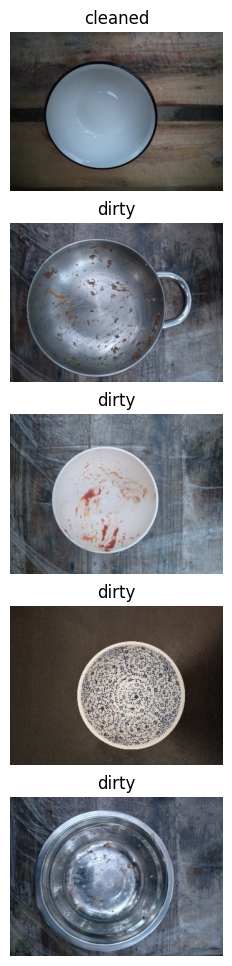

In [23]:
plt.figure(figsize=(12, 12))

for i in range(5):
    title = class_dict[predictions[i][1]]
    image = Image.open(predictions[i][0])

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [22]:
ids = []
labels = []

for path, label in predictions:
    id = os.path.basename(path).split('.')[0]
    ids.append(id)
    labels.append(class_dict[label])

res = pd.DataFrame({'id': ids, 'label': labels})
res.to_csv('/kaggle/working/submission_.csv', index=False)